In [1]:
import tensorflow as tf
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm import tqdm
import pickle
import seaborn as sns
mpl.rcParams['figure.dpi'] = 350

k562_bpnet = tf.keras.models.load_model('/kaggle/input/chrombpnet-data/k562_chrombpnet_wo_bias.h5', compile=False)
gm12878_bpnet = tf.keras.models.load_model('/kaggle/input/chrombpnet-data/gm12878_chrombpnet_wo_bias.h5', compile=False)
hepg2_bpnet = tf.keras.models.load_model('/kaggle/input/chrombpnet-data/hepg2_chrombpnet_wo_bias.h5', compile=False)
h1esc_bpnet = tf.keras.models.load_model('/kaggle/input/chrombpnet-data/h1esc_chrombpnet_wo_bias.h5', compile=False)
df = pd.read_csv('/kaggle/input/chrombpnet-data/processed_data_removed.txt')

In [2]:
import pandas as pd
df = pd.read_csv('/kaggle/input/chrombpnet-data/processed_data_removed.txt')
df.head()

,Unnamed: 0,dhs_id,chrom,chromStart,chromEnd,DHS_width,summit,numsamples,total_signal,component,proportion,GM12878_ENCLB441ZZZ,hESCT0_ENCLB449ZZZ,K562_ENCLB843GMH,HepG2_ENCLB029COU,TAG,addtional_rep_with_this_peak,other_samples_with_this_peak_not_considering_reps,data_label,Full_Sequence
0,0,chr14_92895527_92895734_92895650,chr14,92894573,92896687,207,92895650,2,2.41656,1,0.508887,1,0,0,0,GM12878_ENCLB441ZZZ,1,0,training,CTTGGTTGCCAGTGGAAATGGCAGCAGGAAGAACACACTGCCTCTT...
1,1,chr16_84088800_84089180_84088970,chr16,84087933,84090047,380,84088970,2,5.17234,1,0.508887,1,0,0,0,GM12878_ENCLB441ZZZ,1,0,training,TAACAAACCTGCAGCTGGAAACTGGATCCCTTTTAAACCAGCCGCC...
2,2,chr17_63517040_63517143_63517070,chr17,63516034,63518148,103,63517070,2,1.41943,1,0.508887,1,0,0,0,GM12878_ENCLB441ZZZ,1,0,training,ACCCTAGTGGAACTAGACACCCACGCACCCATTGCCTGATTGGGGA...
3,3,chr5_95617159_95617377_95617270,chr5,95616211,95618325,218,95617270,2,4.34546,1,0.508887,1,0,0,0,GM12878_ENCLB441ZZZ,1,0,training,GCATCCAGATTCAACTGCTAATCAGAAAATCTGGGTTTTGGCCCCT...
4,4,chr5_151721128_151721540_151721390,chr5,151720277,151722391,412,151721390,2,8.54241,1,0.508887,1,0,0,0,GM12878_ENCLB441ZZZ,1,0,training,ACTGGTGTGAGATGATATCTAATAGTGGTTTTGATTTGCATTTCTC...


# Extending Sequences to length 2114

In [3]:
!pip install ucsc_genomes_downloader
from ucsc_genomes_downloader import Genome
hg38 = Genome(assembly="hg38")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.4/293.4 kB 1.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ucsc_genomes_downloader: filename=ucsc_genomes_downloader-1.1.26-py3-none-any.whl size=14974 sha256=1b4d471e2ecc046e9837645644009cea310b28715d5a028240ac65e9baa29d78
  Stored in directory: /root/.cache/pip/wheels/37/b6/77/31467f98789328aab176cbde40dcf81386855ad65bf235a853
  Created wheel for compress_json: filename=compress_json-1.0.8-py3-none-any.whl size=4730 sha256=ba39c7e872049355b8569061ea34f47328df3d5e974e6817c540170dadcf647c
  Stored in directory: /root/.cache/pip/wheels/93/9f/a4/13810037c24ad31f1f42fe769d4cbe6665d8d081c322b3483b
  Created wheel for

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

In [4]:
df = df.rename(columns={'chr': 'chrom', 'start': 'chromStart', 'end': 'chromEnd'})

a = []
b = []
for ind, row in df.iterrows():
    flank_len = (2114 - (row['chromEnd'] - row['chromStart']))//2
    a1 = row['chromEnd'] + flank_len
    b1 = row['chromStart'] - flank_len
    if a1 - b1 == 2113:
        b1 -= 1
    elif a1 - b1 == 2115:
        b1 += 1
    b.append(b1)
    a.append(a1)
df['chromEnd'] = a
df['chromStart'] = b

sequences = hg38.bed_to_sequence(df)
for i in range(len(sequences)):
    sequences[i] = sequences[i].upper()

df['Full_Sequence'] = sequences
df.to_csv('processed_data.txt', sep=',', header=True)
indices = []
for i, j in enumerate(sequences):
    if len(j) != 2114: indices.append(i)
df_removed = df.drop(indices)
df.to_csv('processed_data_removed.txt', sep=',', header=True, index=False)

In [5]:
full_sequences = df['Full_Sequence']
shuffled_sequences = []
for i in range(len(full_sequences)):
    if type(full_sequences[i]) == str:
        shuffled_sequences.append(''.join(random.sample(full_sequences[i], len(full_sequences[i]))))
    else:
        shuffled_sequences.append(full_sequences[i])

df['Shuffled_Sequence'] = shuffled_sequences

# Running chrombpnet

In [8]:
def preprocess_sequence(seq):
    letter2ind = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    sequence = []
    for i in range(2114): sequence.append(letter2ind[seq[i]])
    sequence = np.array(sequence)
    b = np.zeros((sequence.size, sequence.max() + 1))
    b[np.arange(sequence.size), sequence] = 1
    return b[None, :]

def plot_chrom_accessibility(k562_output, gm12878_output, hepg2_output, h1esc_output, window=200):
    one_kb_window = int((window//2)/2114*1000)
    plt.plot(list(range(94)), k562_output[0][0, 500-one_kb_window:500+one_kb_window], "r-")
    plt.plot(list(range(94)), gm12878_output[0][0, 500-one_kb_window:500+one_kb_window], "g-")
    plt.plot(list(range(94)), hepg2_output[0][0, 500-one_kb_window:500+one_kb_window], "b-")
    plt.plot(list(range(94)), h1esc_output[0][0, 500-one_kb_window:500+one_kb_window], "y-")
    plt.title('Chromatin Accessibility')
    
def quantile_normalization(A):
        AA = np.zeros_like(A)
        I = np.argsort(A, axis=0)
        AA[I, np.arange(A.shape[1])] = np.mean(A[I, np.arange(A.shape[1])], axis=1)[:, np.newaxis]
        return AA

def create_boxplots(heatmap, title, labels=['GM12878', 'H1ESC', 'K562', 'HEPG2']):
    plt.boxplot(heatmap)
    plt.xticks(list(range(1, len(labels)+1)), labels)
    plt.title(title)
    
def shuffle_sequence(seq):
    ''.join(random.sample(seq, len(seq)))

In [14]:
heatmap = []
labels = []

for row_num, row in tqdm(df.iterrows(), total=df.shape[0]):
    curr_seq = row['Full_Sequence']
    if type(curr_seq) != str or 'N' in curr_seq: continue
    curr_seq = preprocess_sequence(curr_seq)
    cell_type = row['TAG'][:row['TAG'].index('_')]
    for a, seq in enumerate([curr_seq, preprocess_sequence(row['Shuffled_Sequence'])]):
        gm12878_output = np.mean(gm12878_bpnet(seq)[0][0, 453:547])
        h1esc_output = np.mean(h1esc_bpnet(seq)[0][0, 453:547])
        k562_output = np.mean(k562_bpnet(seq)[0][0, 453:547])
        hepg2_output = np.mean(hepg2_bpnet(seq)[0][0, 453:547])
        heatmap.append([gm12878_output, h1esc_output, k562_output, hepg2_output])
        if a == 0: labels.append(cell_type + str(row_num))
        else: labels.append('Random' + str(row_num))

raw_heatmap = np.array(heatmap)
normalized_heatmap = quantile_normalization(raw_heatmap)

# Plots
## Heatmap

100%|██████████| 47872/47872 [00:32<00:00, 1480.83it/s]


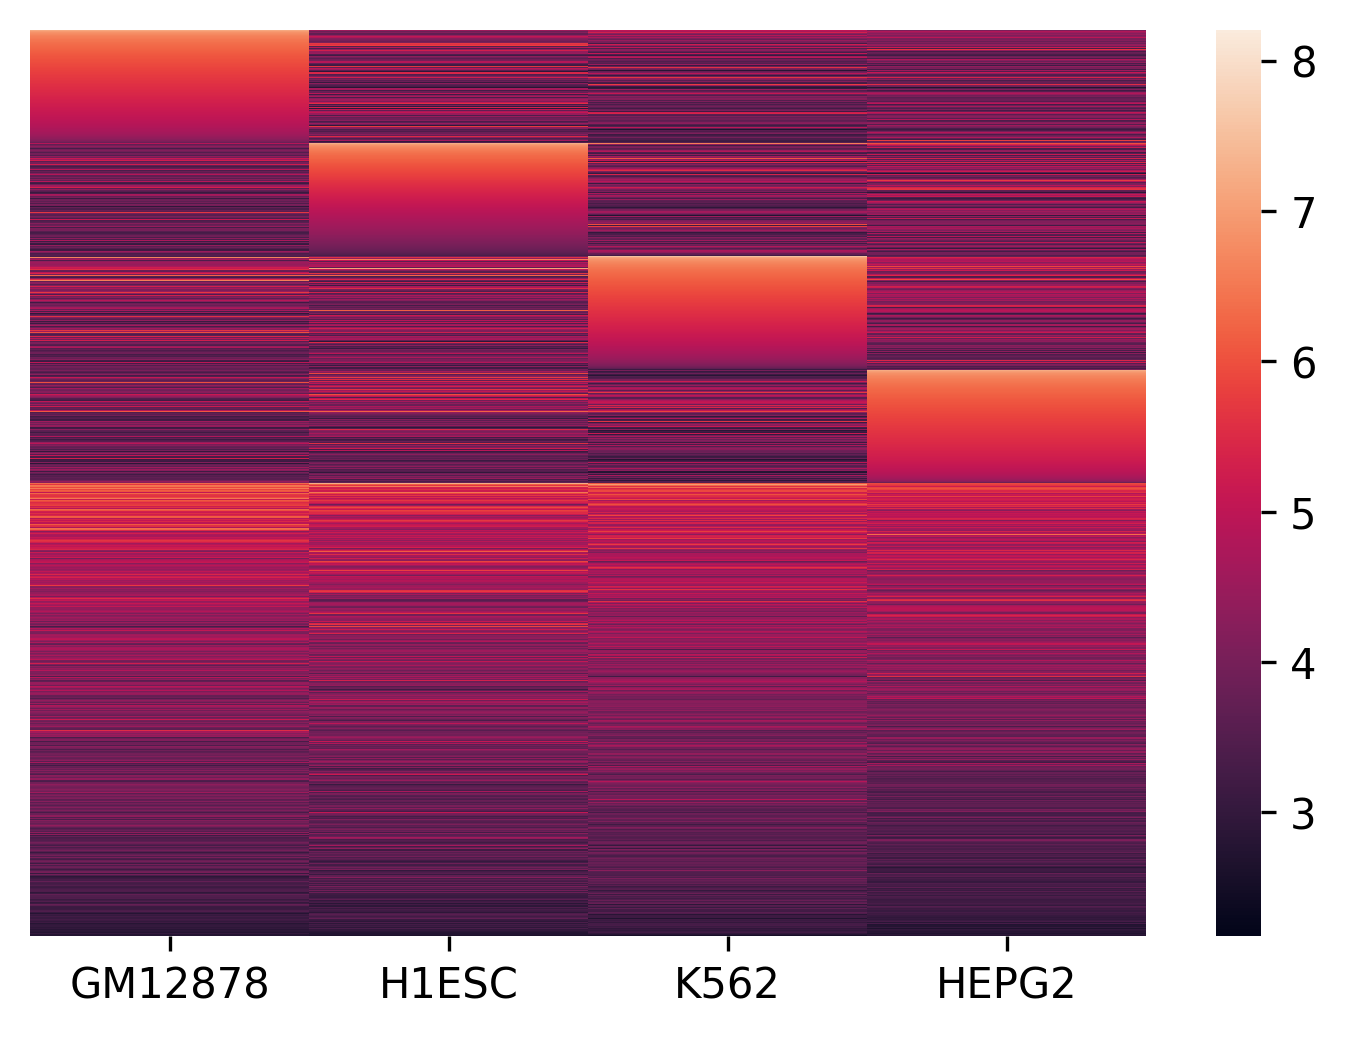

In [22]:
# New heatmap
ordered_preds = {'G': [], 'H': [], 'K': [], 'h': [], 'R': []} # gm12878, hepg2, k562, hesct0, random
with open('/kaggle/input/chrombpnet-data/heatmap_normalized.pickle', 'rb') as f:
    normalized_heatmap = pickle.load(f)
    
heatmap_ind = 0
for row_num, row in tqdm(df.iterrows(), total=df.shape[0]):
    curr_seq = row['Full_Sequence']
    if type(curr_seq) != str or 'N' in curr_seq: continue
    cell_type = row['TAG'][:row['TAG'].index('_')]
    for a, seq in enumerate([curr_seq, preprocess_sequence(row['Shuffled_Sequence'])]):
        if a == 0: ordered_preds[cell_type[0]].append([normalized_heatmap[heatmap_ind][0], normalized_heatmap[heatmap_ind][1], normalized_heatmap[heatmap_ind][2], normalized_heatmap[heatmap_ind][3]])
        else: ordered_preds['R'].append([normalized_heatmap[heatmap_ind][0], normalized_heatmap[heatmap_ind][1], normalized_heatmap[heatmap_ind][2], normalized_heatmap[heatmap_ind][3]])
        heatmap_ind += 1

ordered_preds['G'].sort(reverse=True, key = lambda x: x[0])
ordered_preds['h'].sort(reverse=True, key = lambda x: x[1])
ordered_preds['K'].sort(reverse=True, key = lambda x: x[2])
ordered_preds['H'].sort(reverse=True, key = lambda x: x[3])
ordered_preds['R'].sort(reverse=True, key = lambda x: sum(x)/4)
ordered_predictions = ordered_preds['G'] + ordered_preds['h'] + ordered_preds['K'] + ordered_preds['H'] + ordered_preds['R']
ordered_predictions = np.array(ordered_predictions)

mpl.rcParams['figure.dpi'] = 300
ax = sns.heatmap(ordered_predictions, xticklabels=["GM12878", "H1ESC", "K562", "HEPG2"])
ax.set(yticks=[])
ax.tick_params(left=False)

## Quantile Normalization Box plots

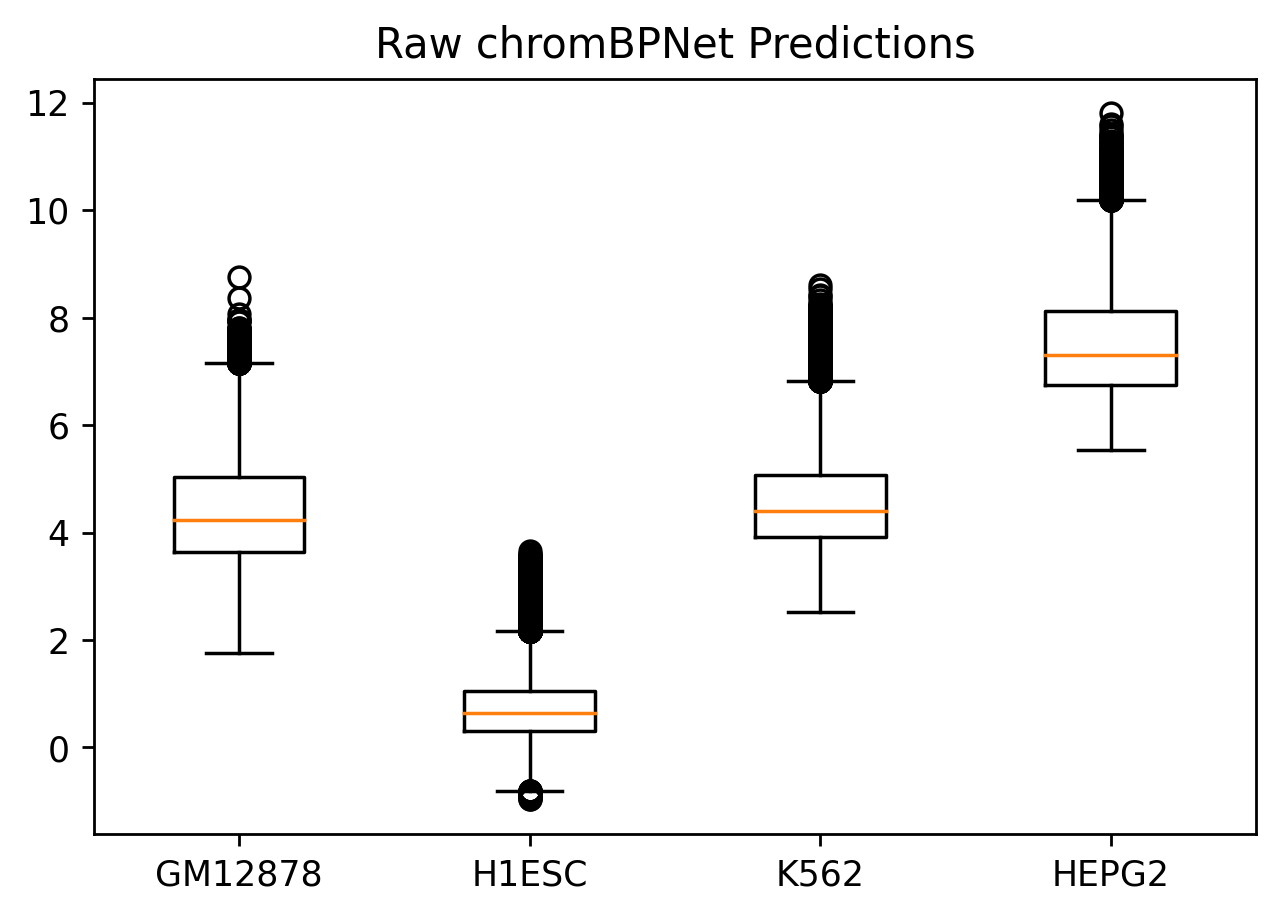

In [12]:
create_boxplots(raw_heatmap, 'Raw chromBPNet Predictions')

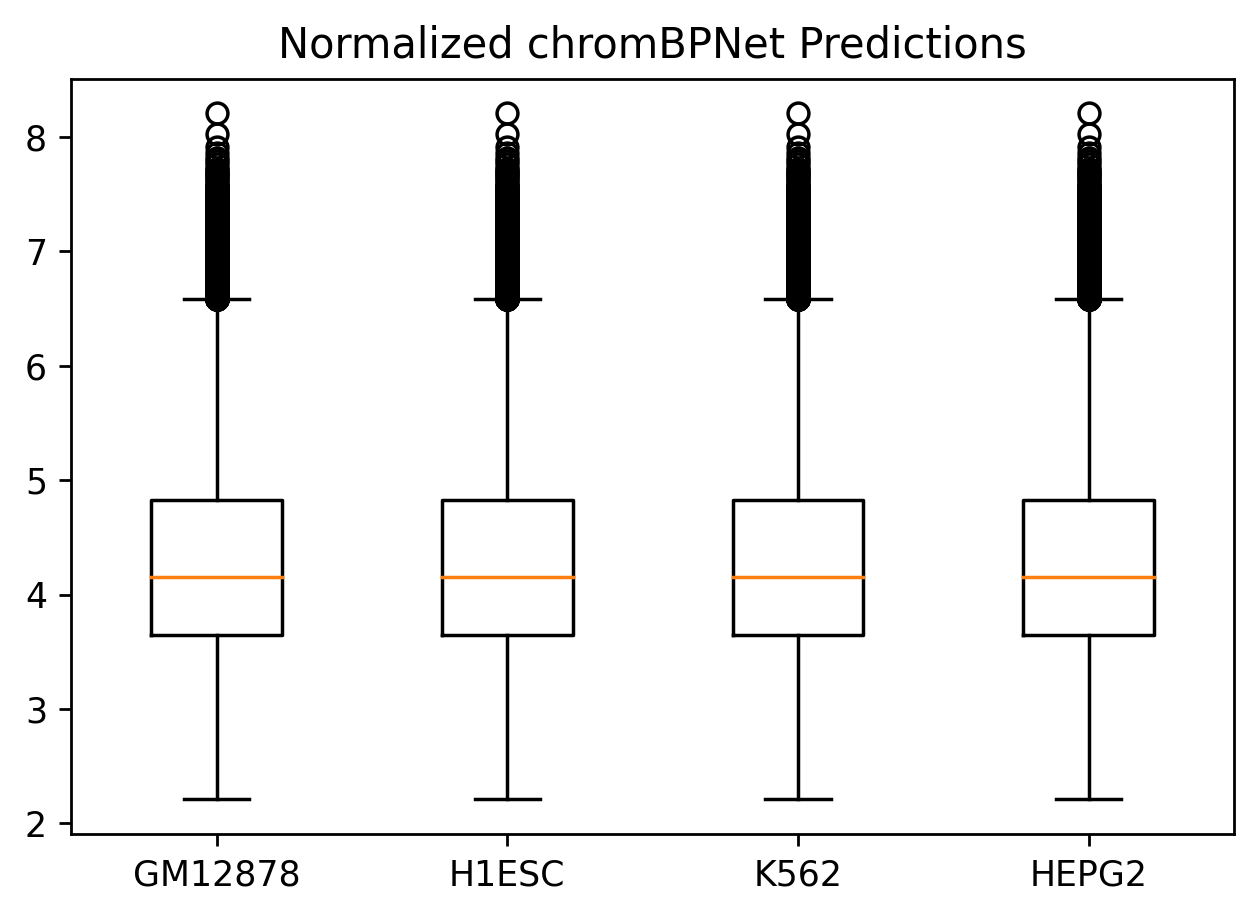

In [13]:
create_boxplots(normalized_heatmap, 'Normalized chromBPNet Predictions')

# New Sequence Evaluation

In [21]:
cell_sequences = {'G': [], 'H': [], 'K': [], 'h': []}
diffused_sequence_heatmap = [[], [], [], []]
original_sequence_heatmap = [[], [], [], []]
for row_num, row in df.iterrows():
    curr_seq = row['Full_Sequence']
    if type(curr_seq) != str or 'N' in curr_seq: continue
    cell_type = row['TAG'][:row['TAG'].index('_')]
    cell_sequences[cell_type[0]].append(curr_seq)

# Right Context
def evaluate_sequence(seq, cell_type, right_context=True, N=15):
    predictions = []
    gm_sequences = random.sample(cell_sequences['G'], 100)
    hep_sequences = random.sample(cell_sequences['H'], 100)
    k_sequences = random.sample(cell_sequences['K'], 100)
    h1_sequences = random.sample(cell_sequences['h'], 100)
    if not right_context:
        for i in range(len(gm_sequences)):
            gm_sequences[i] = shuffle_sequence(gm_sequences[i])
            hep_sequences[i] = shuffle_sequence(hep_sequences[i])
            k_sequences[i] = shuffle_sequence(k_sequences[i])
            h1_sequences[i] = shuffle_sequence(h1_sequences[i])
    
    for i in range(100):
        gm1_output = np.mean(gm12878_bpnet(preprocess_sequence(gm_sequences[i][:957] + seq + gm_sequences[i][1157:]))[0][0, 453:547])
        h11_output = np.mean(h1esc_bpnet(preprocess_sequence(h1_sequences[i][:957] + seq + h1_sequences[i][1157:]))[0][0, 453:547])
        k1_output = np.mean(k562_bpnet(preprocess_sequence(k_sequences[i][:957] + seq + k_sequences[i][1157:]))[0][0, 453:547])
        hep1_output = np.mean(hepg2_bpnet(preprocess_sequence(hep_sequences[i][:957] + seq + hep_sequences[i][1157:]))[0][0, 453:547])
        
        gm2_output = np.mean(gm12878_bpnet(preprocess_sequence(gm_sequences[i]))[0][0, 453:547])
        h12_output = np.mean(h1esc_bpnet(preprocess_sequence(h1_sequences[i]))[0][0, 453:547])
        k2_output = np.mean(k562_bpnet(preprocess_sequence(k_sequences[i]))[0][0, 453:547])
        hep2_output = np.mean(hepg2_bpnet(preprocess_sequence(hep_sequences[i]))[0][0, 453:547])
        predictions.append([gm1_output, h11_output, k1_output, hep1_output, gm2_output, h12_output, k2_output, hep2_output])
    
    predictions = np.array(predictions)
    medians = np.median(predictions, axis=0)
    diffused_sequence_heatmap[cell_type].append(medians[:4])
    original_sequence_heatmap[cell_type].append(medians[4:])
#     predictions = quantile_normalization(predictions)
#     create_boxplots(predictions, 'Diffused ' + cell_type + ' Sequence', ['GM12878', 'H1ESC', 'K562', 'HEPG2', 'GM12878\nOriginal', 'H1ESC\nOriginal', 'K562\nOriginal', 'HEPG2\nOriginal'])

In [ ]:
gm_lines = open('/kaggle/input/chrombpnet-data/epoch5000_synthetic_motifs_GM12878_ENCLB441ZZZ.fasta', 'r').readlines()
h1_lines = open('/kaggle/input/chrombpnet-data/epoch5000_synthetic_motifs_hESCT0_ENCLB449ZZZ.fasta', 'r').readlines()
k_lines = open('/kaggle/input/chrombpnet-data/epoch5000_synthetic_motifs_K562_ENCLB843GMH.fasta', 'r').readlines()
hep_lines = open('/kaggle/input/chrombpnet-data/epoch5000_synthetic_motifs_HepG2_ENCLB029COU.fasta', 'r').readlines()
for i in range(1, len(gm_lines), 2): evaluate_sequence(gm_lines[i].strip(), 0)
print("Done!")
for i in range(1, len(h1_lines), 2): evaluate_sequence(h1_lines[i].strip(), 1)
print("Done!")
for i in range(1, len(k_lines), 2): evaluate_sequence(k_lines[i].strip(), 2)
print("Done!")
for i in range(1, len(hep_lines), 2): evaluate_sequence(hep_lines[i].strip(), 3)
print("Done!")

Done!
Done!


100%|██████████| 100/100 [03:30<00:00,  2.10s/it]


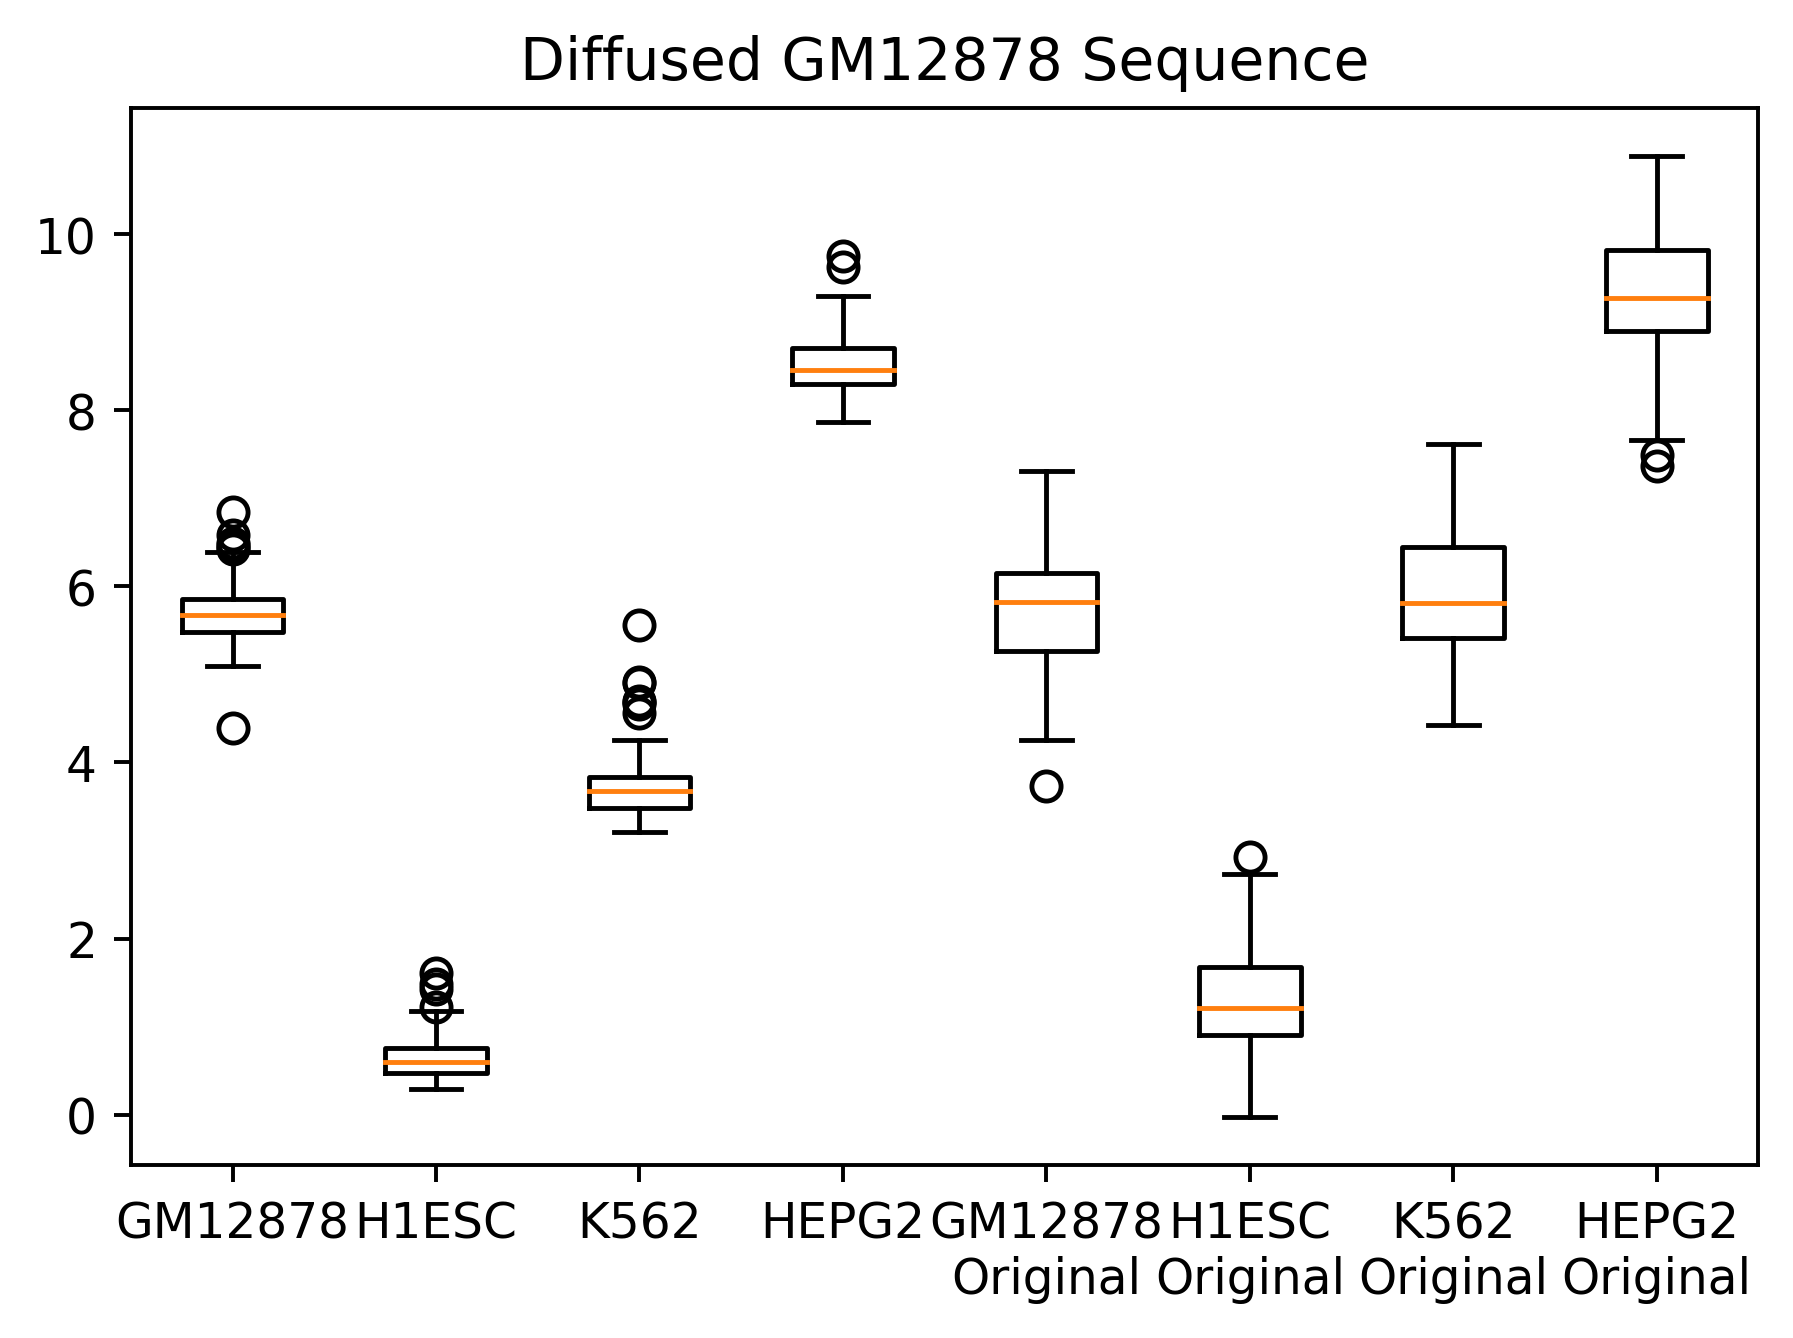

In [72]:
lines = open('/kaggle/input/chrombpnet-data/epoch5000_synthetic_motifs_GM12878_ENCLB441ZZZ.fasta', 'r').readlines()
sample_gm_seq = lines[1].strip()
evaluate_sequence(sample_gm_seq, 'GM12878')